# Kaggle - G-Research Crypto Forecasting | Data Exploration

In this notebook we do an initial exploration of the data and construct some features for model fitting.

Warning: The Python library associated with this notebook will likely change, so these results may not exactly be reprodicible. Ideally this would be fixed by placing the notebook into version control with that library - I don't do this for simplicity.

In [1]:
import numpy as np
import pandas as pd

from lib.transformations import *
from lib.utils import *
from lib.features import *
from lib.data_utils import *
from lib.metrics import *
from lib.models import *


%load_ext autoreload
%autoreload 2

## Load + Pivot Data

In [3]:
df = pd.read_csv("train.csv")
ad = pd.read_csv("asset_details.csv").set_index("Asset_ID")

# define normalised weights to define the 'market' value of features for later
weights = ad["Weight"]
weights /= weights.sum()

df.groupby("Asset_ID").apply(lambda x: x.isna().sum()) # targets are missing values (due to beta netrualisation)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
Asset_ID,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,13415
1,0,0,0,0,0,0,0,0,0,304
2,0,0,0,0,0,0,0,0,0,4861
3,0,0,0,0,0,0,0,0,0,18731
4,0,0,0,0,0,0,0,0,0,144974
5,0,0,0,0,0,0,0,0,0,2302
6,0,0,0,0,0,0,0,0,0,340
7,0,0,0,0,0,0,0,0,0,9326
8,0,0,0,0,0,0,0,0,0,193106


## Data inspection

In [4]:
all_timestamps = np.sort(df.timestamp.unique())
missing_dts = list(set(range(all_timestamps[0],all_timestamps[-1]+60,60)) - set(all_timestamps))
len(missing_dts), len(missing_dts) / len(all_timestamps)

(178, 9.096567732123456e-05)

Missing data at the start of each month + issues on 2019-10-16 + 2019-10-23

In [5]:
missing_dts_ = [to_dt(k) for k in missing_dts]
pd.Series([x.strftime('%Y-%m-%d %H:%M:%S') for x in sorted(missing_dts_)])

0      2018-02-01 00:00:00
1      2018-03-01 00:00:00
2      2018-04-01 00:00:00
3      2018-05-01 00:00:00
4      2018-06-01 00:00:00
              ...         
173    2021-05-01 00:00:00
174    2021-06-01 00:00:00
175    2021-07-01 00:00:00
176    2021-08-01 00:00:00
177    2021-09-01 00:00:00
Length: 178, dtype: object

<AxesSubplot:xlabel='timestamp'>

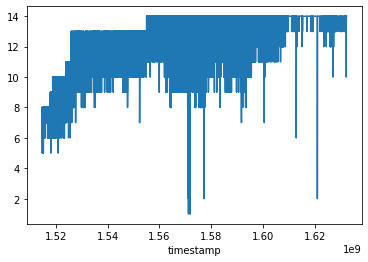

In [6]:
# less securities available at the start and sudden drops throughout
asset_cts = df.groupby("timestamp")["Asset_ID"].count()
asset_cts.plot()

In [7]:
ct_dec = asset_cts[asset_cts.diff()<0]
ct_dec_diff = np.diff(ct_dec.index.values)
pd.Series(ct_dec_diff).describe().round(0)
# looks like this doesn't happen too regularly, so forward filling should be okay

count     289468.0
mean         405.0
std         7447.0
min           60.0
25%          120.0
50%          180.0
75%          300.0
max      1697580.0
dtype: float64

### Train, test split
Split into train, test sets in a 80:20 ratio - in this exploratory notebook we only make use of the test set.

(Reminder: Data is from 2018-01 to 2021-09)

In [30]:
(train_ts, test_ts), = ts_split(df.timestamp.unique(), 1, 0.2, overlap=16)
train = df[df.timestamp.isin(train_ts)]
# test = df[df.timestamp.isin(test_ts)]

to_dt(df.timestamp.min()), to_dt(df.timestamp.max())

1565425


(datetime.datetime(2018, 1, 1, 0, 1), datetime.datetime(2021, 9, 21, 0, 0))

### Augment with features for each minute bar

In [31]:
bar_feats(train) # augment in place

/opt/conda/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


### Pivot data for constructing some time series features

In [32]:
pivotted_df = pivot_data(train)

## Time series feature construction
We keep these points in mind when constructing features:
- This is a time series modelling problem, so we will generally have non-stationarity issues
  - For a (typical) model to generalise well the input series need to be stationary
  - We normalise explicitly across time for first and second moments
  - Higher moments are difficult to estimate and so are difficult to explicitly neutralise
  - Attempt to reduce outliers/skewness using heuristic power/log transforms
    - (Possibly easier to learn if all inputs are approximately normally distributed)
- The returns are market neutralised so the features should be too
  - eg for trading volume:
    - we only are about volume increases relative to the market
    - if general market volume is increasing, assume this has the same impact across coins
    - hence raw trading volume isn't as interesting as volume *relative* to the market


We need some intuition for relevant timescales for feature construction, so let's plot a few series.

Observations:
- These series are generally non-stationary. We need to neutralise for this in the feature construction.
- Count has clear seasonality
  - Expect this is to do with trading hours -> include features derived from timestamps

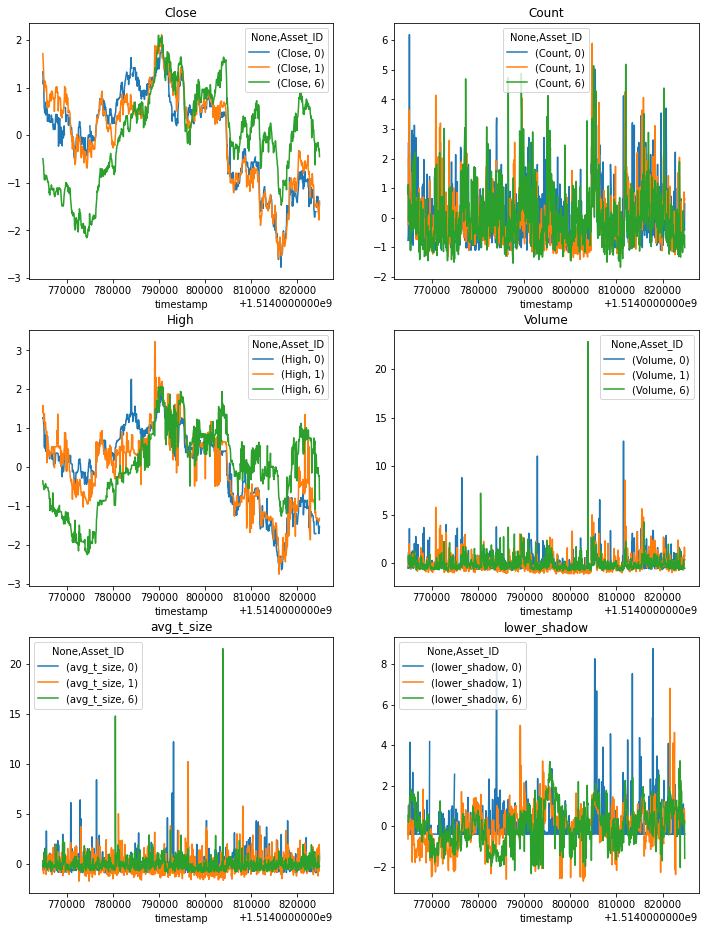

In [34]:
subset_df = pivotted_df.iloc[:1000][["Close", "High", "Volume", "Count", "avg_t_size", "lower_shadow"]]
subset_df = subset_df.sub(subset_df.mean()) / subset_df.std()
subset_cols = [0, 1, 6] # btc, eth + 1 other

fig, ax = plt.subplots(3, 2, figsize=(12, 16))

for (k, grp), ax_ in zip(subset_df.groupby(level=0, axis=1), ax.reshape(-1)):
    _ = grp.loc[:, np.in1d(grp.columns.get_level_values(1), subset_cols)].plot(subplots=False, title=k, ax=ax_)

### Target inspection
Let's look at acfs for residual 15 minute returns (vertical red lines are at `15*n, n=1, 2, ...`). There are clear correlations for certain lags + *some* consistency between assets.

This suggests price momentum features will be helpful when constructed over some appropriate horizons - visually these are roughly over `15, 30, 60, 80, 100, 115` minutes.

Note: We are looking at the first 20000 returns data points, so if these correlations are spurious we'd expect performance to be worse outside of this set.

Reminder: these observations may not be statistically significant - let's ignore this since the details are messy (15 minute returns are not independent, multiple testing issues etc).


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:461: RuntimeWarning: invalid value encountered in double_scalars
  xo = x - x.sum() / notmask_int.sum()


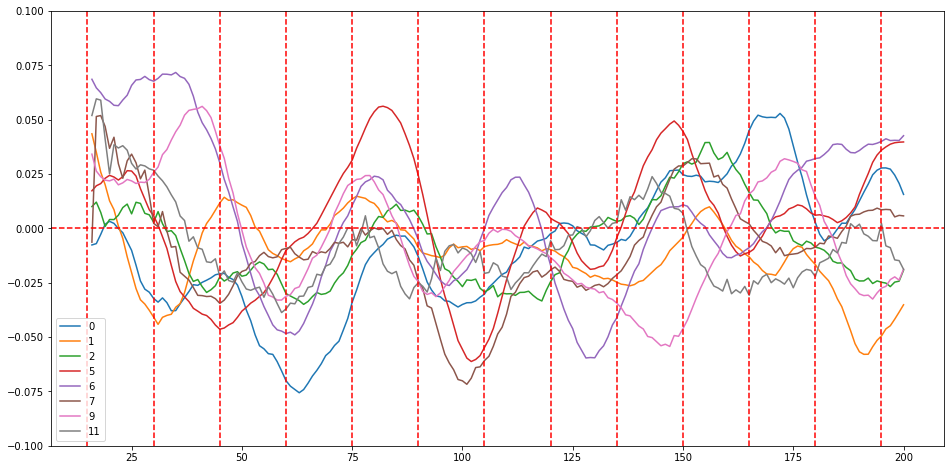

In [155]:
vlines = np.arange(15, 200, 15)
from lib.utils import  calc_acf
acfs = calc_acf(pivotted_df["Target"].iloc[:20000], nlags=200)

pd.DataFrame(acfs).loc[16:].plot(figsize=(16, 8))
plt.axhline(y=0, color='r', linestyle='--')
[plt.axvline(x, color='r', linestyle='--') for x in vlines] # 15*n
_ = plt.ylim([-0.1, 0.1])

### Feature Neutralisation
We are predicting market neutralised returns, so features should also be "market neutralised" - we do this in a similar way as for returns.

For this example there is a reduction in the first PC variance (interpreted as the market factor) so idiosyncratic (not systematic/market) information should now be driving feature values.

We do this (where appropriate) for all input features.

In [14]:
example_feat = pivotted_df["rel_avg"].iloc[-10000:]
neut_example_feat = neut_mkt(example_feat.iloc[-10000:], weights=weights, window=3750, min_window=300)

print(calc_expl_vars(example_feat.dropna(), 5))
print(calc_expl_vars(neut_example_feat.dropna(), 5))

[0.41343699 0.07013006 0.0655992  0.06322671 0.06019261]
[0.15347356 0.09064444 0.08394023 0.08021299 0.07565899]


### Price Momenutm Features
Let's construct some price momentum + volatility momentum series using the target observations.

The price momentum features below are constructed from beta neutralised returns, so no further normalisation is needed.

In [22]:
windows = (1, 5, 15, 30, 80) # add some smaller windows 
mean_std_windows = ((15, 300), (60, 1200))
resid_rets = neut_returns(pivotted_df["Close"], weights, windows)
price_feats_ = price_mom_feats(resid_rets)
vol_feats_ = vol_feats(resid_rets[1], pivotted_df["rel_dev"], mean_std_windows)

/opt/conda/lib/python3.9/site-packages/pandas/core/window/rolling.py:531: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods)
/opt/conda/lib/python3.9/site-packages/pandas/core/window/rolling.py:531: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods)


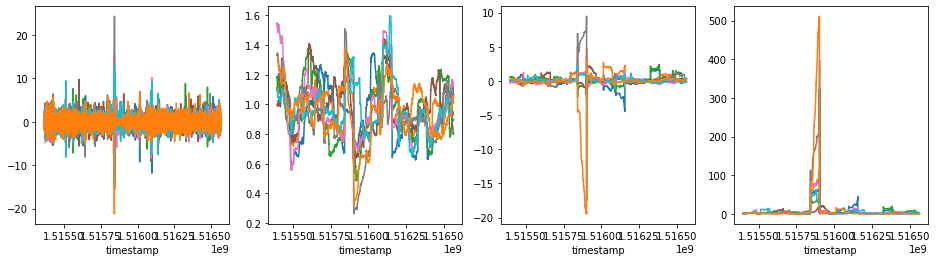

In [ ]:
plot_moments(price_feats_["price_mom"][5].iloc[10000:30000], 1000)
# no obvious visual trends, but clear outliers -> remove before training

/opt/conda/lib/python3.9/site-packages/pandas/core/window/rolling.py:531: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods)
/opt/conda/lib/python3.9/site-packages/pandas/core/window/rolling.py:531: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods)


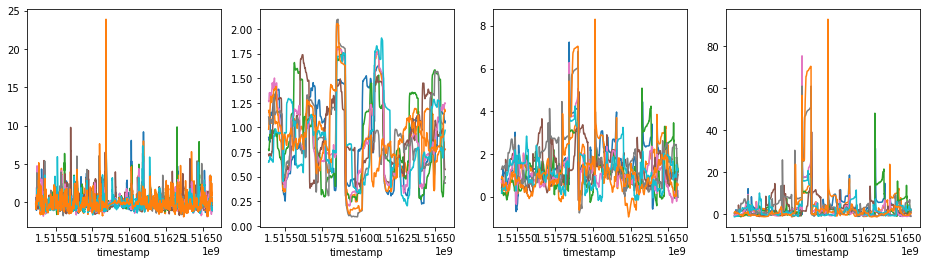

In [ ]:
plot_moments(price_feats_["vol_mom"][5].iloc[10000:30000], 1000)
# same as above, but clear data quality issues, so need to address before fitting any models

### Transaction Features
Construct features relating to trading activity (trading volume, etc). We neutralise for market beta by normalising by market activity, specifically for the fields: Volume, Count, dollar_vol, avg_t_size

In [24]:
mean_std_windows = ((15, 300), (120, 1500))
prop_feats_ = transaction_feats(pivotted_df, mean_std_windows, shrink_prop=0.2)

/opt/conda/lib/python3.9/site-packages/pandas/core/window/rolling.py:531: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods)
/opt/conda/lib/python3.9/site-packages/pandas/core/window/rolling.py:531: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods)


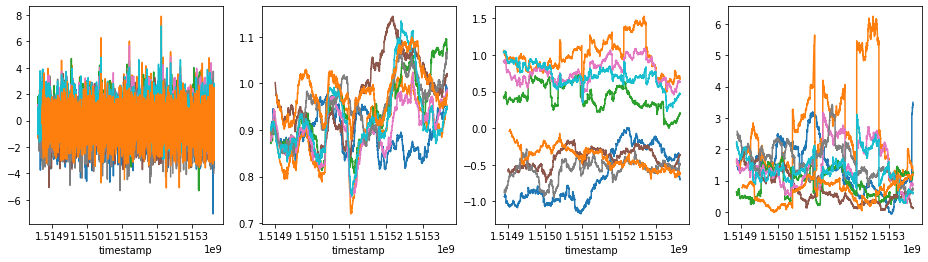

In [ ]:
plot_moments(prop_feats_['dollar_vol_prop'][120].iloc[:10000], 1000) # normalisation seems okay

### Rolling Features
For the remaining features, we construct neutralised features by beta neutralising and then make stationary via a z-score transformation.



In [42]:
std_window = 3000
roll_feats = rolling_feats(pivotted_df, weights, std_window, shrink_prop=0.2)

/opt/conda/lib/python3.9/site-packages/pandas/core/window/rolling.py:531: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods)
/opt/conda/lib/python3.9/site-packages/pandas/core/window/rolling.py:531: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods)


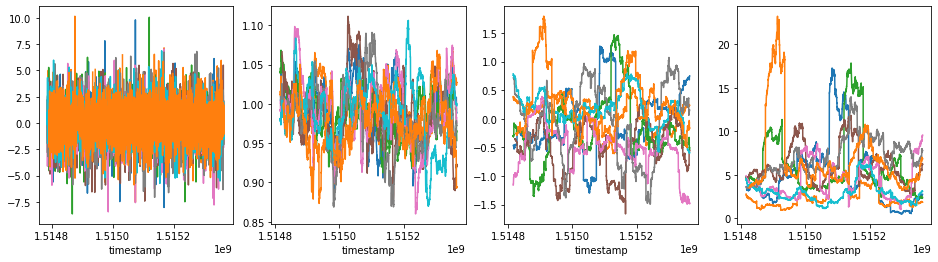

In [ ]:
plot_moments(roll_feats['rel_avg_open'][120].iloc[:10000], 1000) # normalisation seems okay

### Shifted Features
We are modelling time series, so it is natural to include shifted features:
- Don't shift all features since this significantly increases feature dimensionality.
- Prefer to shift the 'short window' features (features constructed over short windows of data)
  - These change quicker than the 'long window' features
  - ... so shifting these features gives more information than the shifting the 'long window' features
- Due to computational constraints, we'll include these right at the end if there is capacity to do so
  - I expect marginal benefits will generally be small

Explicit sequence models (eg LSTM) would also be natural to consider, however for simplicity we'll focus on static models.

# Remaining Target Observations

### Clustering Assets
We expect coins to be correlated (after removing the market factor) in groups, eg Bitcoin + Litecoin since these are similar in structure and are popular. We run KMeans clustering to help determine these clusters.

Note: This clustering is *highly* subjective (... as is the case for most clustering analysis).

We need an input # of clusters for `KMeans`. The asset details suggest a natural split - mainstream coins (ETH, BTC, Litecoin, ...) and other coins (Cardano, IOTA, Dogecoin, ...).

Anecdotally, setting K=3 gives stable clusters.

The groups from running KMeans are (roughly):
- Binance Coin, Cardano, Dogecoin, IOTA, Maker, Monero, Stellar
- Bitcoin, Bitcoin Cash, EOS.IO, Ethereum, Litecoin, TRON
- Ethereum Classic

{1: ['Binance Coin',
  'Cardano',
  'Dogecoin',
  'IOTA',
  'Maker',
  'Monero',
  'Stellar'],
 0: ['Bitcoin', 'Bitcoin Cash', 'EOS.IO', 'Ethereum', 'Litecoin', 'TRON'],
 2: ['Ethereum Classic']}

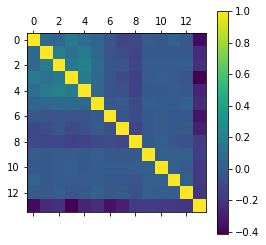

In [ ]:
K = 3
subset_ret = resid_rets[1].loc[1.56e9:]
corr = subset_ret.corr()
clust_ret = cluster_returns(K, corr)
plt.matshow(corr.iloc[clust_ret[1], clust_ret[1]])
plt.colorbar()
{k: [ad.loc[c]["Asset_Name"] for c in v] for k, v in clust_ret[0].items()}

We further split to obtain groups with similar trading volumes:

- Dogecoin, IOTA, Maker, Monero
- Ethereum Classic
- Binance Coin, Cardano, Stellar
- Bitcoin Cash, EOS.IO, TRON
- Bitcoin, Ethereum, Litecoin

In [ ]:
avg_vol = (pivotted_df["dollar_vol"]).iloc[-10000:].median().rename("dollar_vol")
pd.concat([avg_vol, ad_], axis=1).sort_values(by="dollar_vol")

,dollar_vol,Weight,Asset_Name
Asset_ID,,,
10,7.817588e+02,1.098612,Maker
8,1.293611e+03,1.098612,IOTA
4,4.989123e+03,3.555348,Dogecoin
11,7.631552e+03,1.609438,Monero
7,1.922467e+04,2.079442,Ethereum Classic
3,4.299999e+04,4.406719,Cardano
13,4.611772e+04,1.791759,TRON
12,4.658192e+04,2.079442,Stellar
0,4.860915e+04,4.304065,Binance Coin


### What clustering gives us
If a group of assets behave similarly we can:
- Treat the group as a single asset and train a single model on this pooled group (pooling).
  - Gives more data, but assumes features + returns behave in the same way across the group.
- View *all* features for each asset in the group as relevant for predicting returns for each asset (panelling).
  - Possibly increases # of relevant features, but increases dimensionality.

... both are useful since they take advantage of the correlation structure between assets.

We can also view no asset is special so we pool all assets.


### Check target reconstruction error
The returns construction should be identical to the process shown in the competition page so we should have recreated the targets. Let's check this:

In [ ]:
target_reconst = resid_rets[15].shift(-16)

reconst_errors = pd.DataFrame({
    "corr": pivotted_df["Target"].corrwith(target_reconst),
    "roll_corr": pivotted_df["Target"].rolling(1000).corr(target_reconst).median(),
    "abs_diff": (pivotted_df["Target"] - target_reconst).abs().quantile(0.999),
}).T # Target should be close to resid_rets[15]

reconst_errors # very close, >99.9% correlation etc

Asset_ID,0,1,2,3,4,5,6,7,8,9,10,11,12,13
corr,0.669947,0.975467,0.621448,0.752035,0.623844,0.855528,0.984656,0.817680,0.731457,0.968508,0.979704,0.740211,0.836574,0.897074
roll_corr,0.999931,0.999973,0.999960,0.999957,0.752208,0.999965,0.999972,0.999925,0.807295,0.999972,0.999961,0.809781,0.999954,0.999971
abs_diff,0.044008,0.004749,0.074595,0.026848,0.046949,0.029687,0.005137,0.057551,0.044087,0.010606,0.009247,0.040559,0.025349,0.025710


### Target normalisation

The target is non-stationary - its volatility changes over time. This is a problem, so we normalise by the rolling observed volatility: these are the new targets. Reintroduce this factor in the final predictions.

This normalisation should be tradeable, so use the vol of 15 minute residual returns for target normalisation.

Combine exponential + flat window estimates of volatility to reduce estimation errors.

<AxesSubplot:title={'center':'norm'}, xlabel='timestamp'>

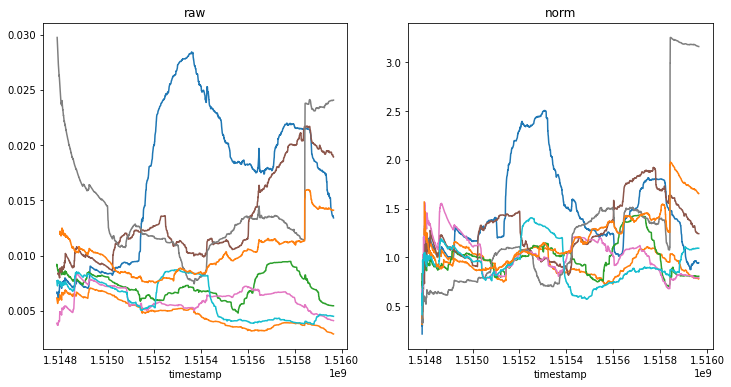

In [137]:
target_std = shrink_std(resid_rets[15], 3000, 0.2, min_window=300)
train_target = pdf["Target"] / target_std

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
pdf["Target"].iloc[:20000].rolling(3750, 300).std().plot(ax=ax[0], legend=False, title="raw")
train_target.iloc[:20000].rolling(3000, 10).std().plot(ax=ax[1], legend=False, title="norm")
# (Visually) much better than before

### Final Observations
Let's look at all of the close price data we have: the last 20% is clearly more volatile than the rest - this could be a problem for training models. Even though we explicitly normalise features for std deviation, changing market conditions could make our models perform worse since 'things could just work differently'. This is a hypothesis and should be tested, however I anticipate models will generally do worse anyway if discarding data when these markets were not as volatile.

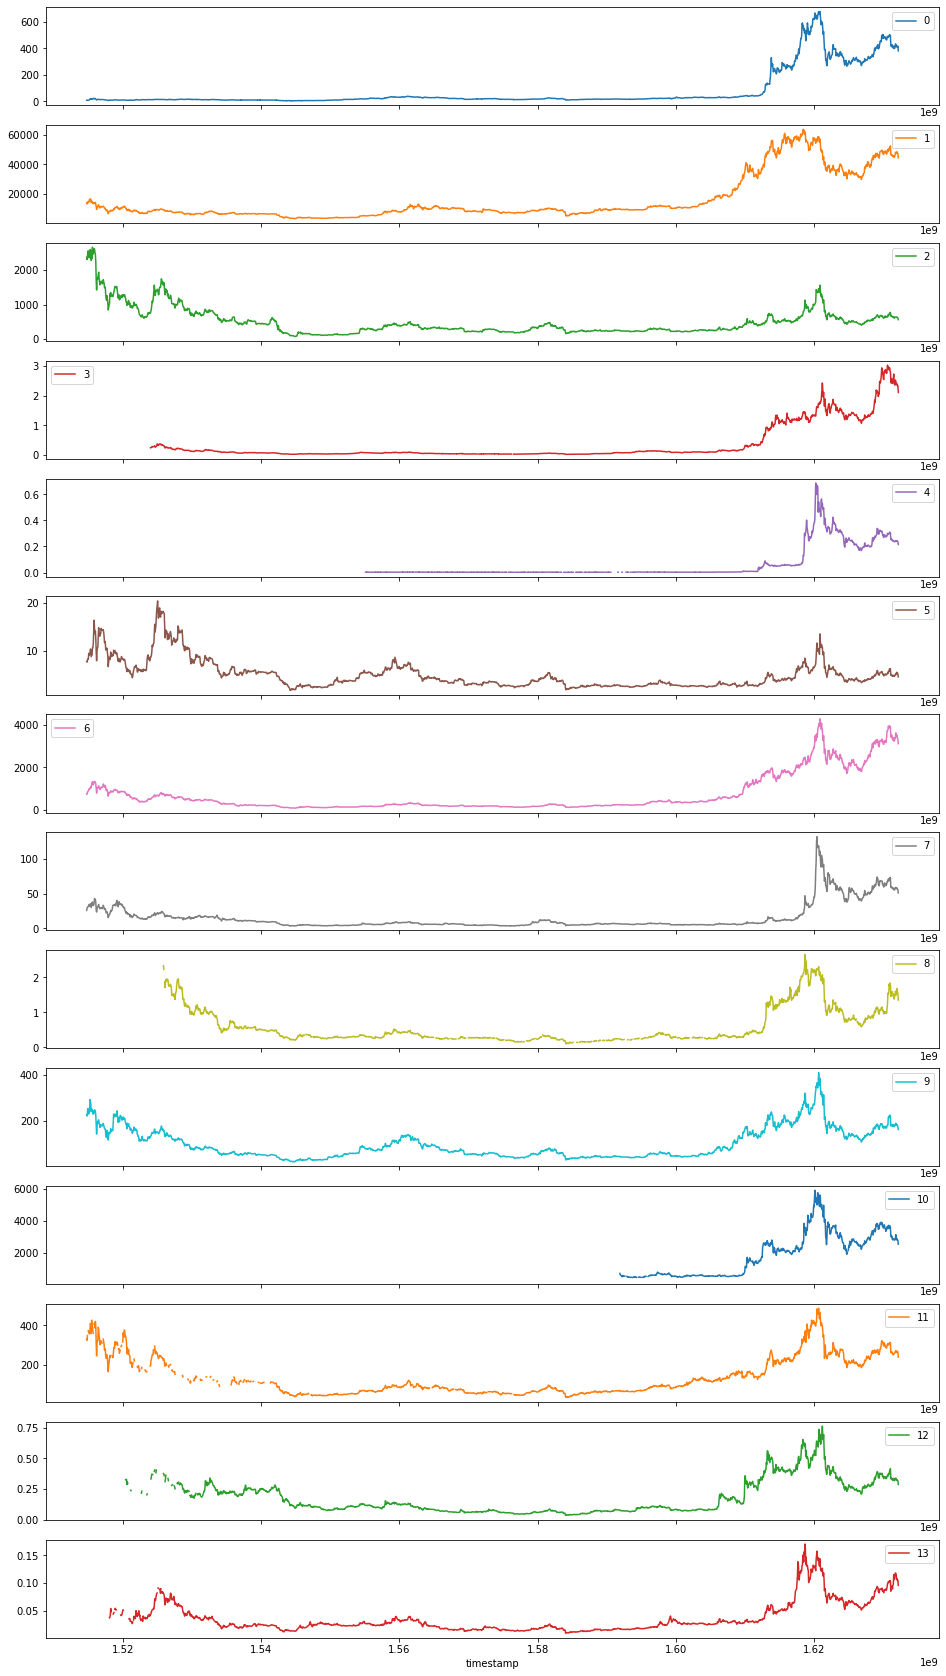

In [15]:
close_prices = df.pivot(index="timestamp", columns="Asset_ID", values="Close")
_ = close_prices.iloc[::1000].plot(figsize=(16, 30), subplots=True)